<a href="https://colab.research.google.com/github/Sergio-Alan/AI-2025/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Final Project: Training a Machine Learning model on medical images.**


Sergio Orlando Alanís De La Rosa 2043932

Diego Castro Galindo 2109304

Sebastian Hernandez Renteria 2109140

Braulio Azael García Treviño 2043046

Miguel Angel Perez Luevano  2052579

**Career**: IB  
**Group**: 003  
**LMV:** N1


# **Preprocessing: Load data and libraries**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
#dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jtiptj/chest-xray-pneumoniacovid19tuberculosis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumoniacovid19tuberculosis' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumoniacovid19tuberculosis


In [ ]:
trainset = f"{path}/train"
valset = f"{path}/val"
testset = f"{path}/test"

#rescaling

img_size = (224, 224)
batch_size = 32

traindatset = image_dataset_from_directory(
    trainset,
    image_size=img_size,
    batch_size=batch_size
    )

valdatset = image_dataset_from_directory(
    valset,
    image_size=img_size,
    batch_size=batch_size
    )

testdatset = image_dataset_from_directory(
    testset,
    image_size=img_size,
    batch_size=batch_size,
    )

original_images, original_labels = next(iter(testdatset))

class_names = testdatset.class_names
print("Classes:", class_names)

Found 6326 files belonging to 4 classes.
Found 38 files belonging to 4 classes.
Found 771 files belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


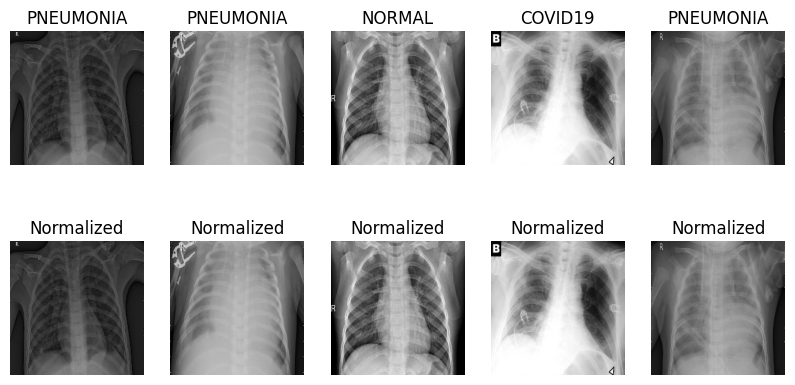

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_images[i].numpy().astype("uint8"))
    plt.title(class_names[original_labels[i]])
    plt.axis("off")


normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_images = normalization_layer(original_images).numpy()
for i in range(5):
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(normalized_images[i].squeeze(), cmap="gray")
    plt.title("Normalized")
    plt.axis("off")

plt.show()


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

traindatset = traindatset.map(lambda x, y: (normalization_layer(x), y))
valdatset = valdatset.map(lambda x, y: (normalization_layer(x), y))
testdatset = testdatset.map(lambda x, y: (normalization_layer(x), y))

## **CNN Structure**

In [ ]:
# Convolutional Base
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
class_counts = np.array([460, 1341, 650, 3875])
total = np.sum(class_counts)

class_weight = {
    i: total / (len(class_counts) * class_counts[i])
    for i in range(len(class_counts))
}

print(class_weight)


{0: np.float64(3.4380434782608695), 1: np.float64(1.1793437733035048), 2: np.float64(2.433076923076923), 3: np.float64(0.4081290322580645)}


In [ ]:
#Compliation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

traindatset = traindatset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valdatset = valdatset.cache().prefetch(buffer_size=AUTOTUNE)
testdatset = testdatset.cache().prefetch(buffer_size=AUTOTUNE)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    traindatset,
    validation_data=valdatset,
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight
)

Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9500 - loss: 0.2128 - val_accuracy: 0.8684 - val_loss: 0.5826
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9585 - loss: 0.1670 - val_accuracy: 0.8684 - val_loss: 0.3742
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9687 - loss: 0.1479 - val_accuracy: 0.8421 - val_loss: 0.7328
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9683 - loss: 0.1178 - val_accuracy: 0.7368 - val_loss: 0.6035
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9681 - loss: 0.1030 - val_accuracy: 0.8947 - val_loss: 0.5115


## **CNN Accuracy Results**

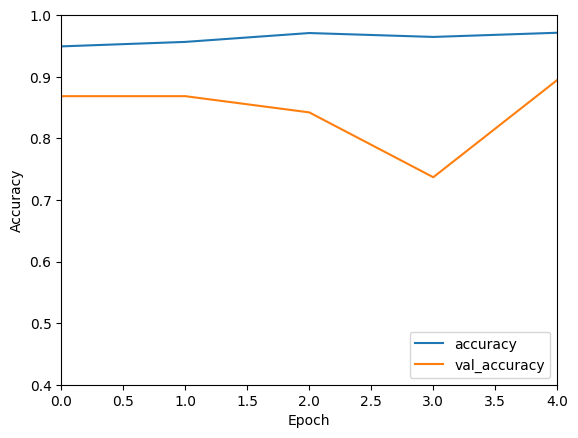

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7732 - loss: 1.1269
Test Accuracy: 0.76


In [ ]:
# Plot with the difference in accuracy values from training and validation.

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.xlim([0, len(history.history['accuracy']) - 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(testdatset)
print(f"Test Accuracy: {test_acc:.2f}")


## **Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


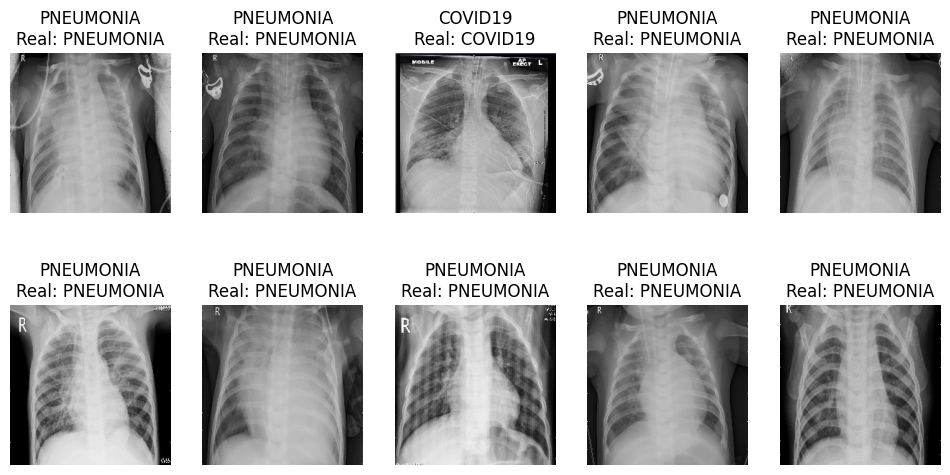

In [ ]:
test_images, test_labels = next(iter(testdatset))
predictions = model.predict(test_images)

plt.figure(figsize=(12, 6))

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)

    pred_idx = np.argmax(predictions[i])
    true_idx = test_labels[i].numpy()

    img = test_images[i].numpy()
    img = img.squeeze()

    plt.imshow(img, cmap="gray")
    plt.title(f"{class_names[pred_idx]}\nReal: {class_names[true_idx]}")
    plt.axis("off")

plt.show()
